HHU Deep Learning, WS2023/24, 26.01.2024

Lecture: Prof. Dr. Markus Kollmann

Exercises: Nikolas Adaloglou, Felix Michels

# Assignment 13 - Adversarial Attacks

---

Submit the solved notebook (not a zip) with your full name plus assignment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 02.02.2024 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/VmmJHs0Iws92Jyk](https://uni-duesseldorf.sciebo.de/s/VmmJHs0Iws92Jyk)

---

This exercise is about Adversarial Attacks. Feel free to have a look at the original [paper](https://arxiv.org/abs/1412.6572) by Goodfellow before writing any code.

### Some Tips and Remarks:

* Use `torch.clamp` for the clip operations.
* You can limit yourself to the first $1000$ images of the test set.
* Do not copy code from anywhere.
* Do not submit the checkpoints or datasets!
* If you run into problems, let us know!

# Part I. Preparation

In [1]:
!wget -c https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a13_adversarial_attack/data.tar.gz
!tar xf data.tar.gz

--2024-01-22 16:26:04--  https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a13_adversarial_attack/data.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a13_adversarial_attack/data.tar.gz [following]
--2024-01-22 16:26:04--  https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a13_adversarial_attack/data.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Part II. Loading a pretrained ResNet18

**Task:** Load the checkpoint `resnet18-cifar10.pth`and validate that the loaded model has a test accuracy of approximately $94\%$.

In [3]:
import torchvision.models as models
from models import ResNet18

# Load the ResNet18 using the given checkpoint
### START CODE HERE ### (approx. 4 lines)
model = ResNet18()
model.to(device)
model.load_state_dict(torch.load('resnet18-cifar10.pth', map_location=device))
model.eval()
### END CODE HERE ###

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Initialise the CIFAR-10 dataset with dataloaders for the train and test sets. Choose the batch_size according to your system hardware. The input images are expected to be normalized to $[-1,1]$!

In [4]:
### START CODE HERE ### (approx. 7 lines)
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='~/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, num_workers=2)

### END CODE HERE ###
test_batch, test_labels = next(iter(testloader))

Files already downloaded and verified
Files already downloaded and verified


Implement the function below which calculates the model accuracy for a given dataloader.

In [5]:
def calc_accuracy(model, device, dataloader):
    correct, total = 0, 0
    ### START CODE HERE ### (approx. 4 lines)
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            total += len(x)
            correct += sum(model(x).argmax(dim=1)==y)
    ### END CODE HERE ###
    return (correct/float(total)).item()

In [6]:
calc_accuracy(model, device, testloader)

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


0.9426999688148499

# Part III. Fast-gradient-sign-method (FGSM)

**Task:** Implement the fast gradient sign method (FGSM) as described in the [paper](https://arxiv.org/abs/1412.6572), section 4. Clip the values of the adversarial image to $[-1,1]$. Assume that the objective $J$ is the cross entropy loss.
Do not modify the input data.

In [7]:
def fgsm(model, device, batch, labels, epsilon):
    """
    Returns adversarial examples of the batch
    """
    batch = batch.to(device)
    labels = labels.to(device)
    ### START CODE HERE ### (approx. 5 lines)
    eta = torch.zeros_like(batch, requires_grad=True)
    loss = F.cross_entropy(model(batch + eta), labels)
    loss.backward()
    update = eta.grad.sign()
    return torch.clamp(batch + epsilon * update, -1, 1).detach()
### END CODE HERE ###

The fooling rate is the relative amount of adversarial images that resulted in a different prediction by the model. Plot different values of $\epsilon$ against the resulting fooling rate on the test images in `test_batch`.

Find a good value for $\epsilon$ that results in a fooling rate of $70\%$ on the test images.

Text(0, 0.5, 'Fooling Rate')

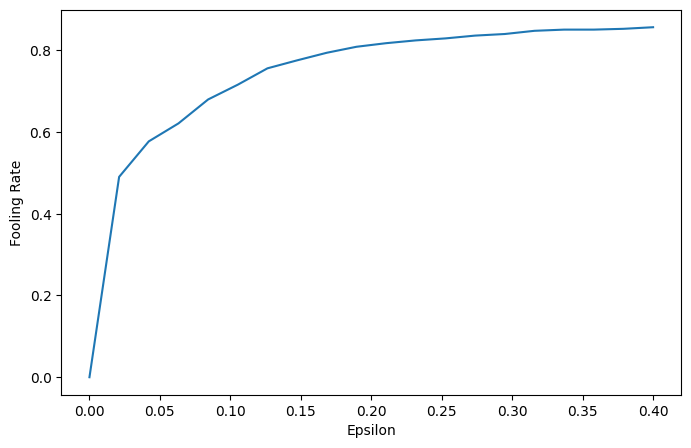

In [8]:
fooling_rates = []
predictions = model(test_batch.to(device)).argmax(1)
### START CODE HERE ### (approx. 5 lines)
for epsilon in torch.linspace(0,0.4,20):
    advs = fgsm(model,
            device,
            test_batch,
            test_labels,
            epsilon=epsilon
           ).cpu()
    adv_predictions = model(advs.to(device)).argmax(1).cpu()
    rate = torch.mean((adv_predictions != predictions.cpu()).float())
    fooling_rates.append(rate)
### END CODE HERE ###
plt.figure(figsize=(8,5))
plt.plot(torch.linspace(0,0.4,20), fooling_rates)
plt.xlabel("Epsilon")
plt.ylabel("Fooling Rate")

### Expected Result

![fooling_rate.png](https://github.com/HHU-MMBS/Deep-Learning-Exercise-Extras/raw/main/a13_adversarial_attack/figs/fooling_rate.png)

In [9]:
# Run the fgsm function with your epsilon
### START CODE HERE ### (approx. 1 lines)
advs = fgsm(model, device, test_batch, test_labels, epsilon=0.1).cpu()
### END CODE HERE ###
perturbations = advs - test_batch

adv_predictions = model(advs.to(device)).argmax(1)
predictions = model(test_batch.to(device)).argmax(1)
(adv_predictions != predictions).float().mean().item()

0.7099609375

Visualize at least $10$ adversarial images and compare them with the original images. Can you recognize the adversarial perturbations?

Check out `torchvision.utils.make_grid` for good-looking plots here.

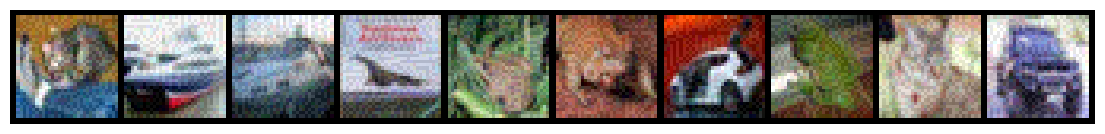

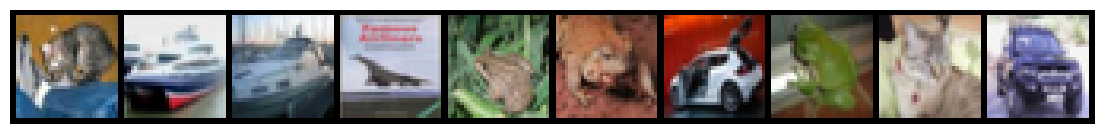

In [10]:
### START CODE HERE ### (approx. 7 lines)
plt.figure(figsize=(14,5))
plt.axis('off')
grid_img = torchvision.utils.make_grid(advs[0:10], nrow=10,normalize=True)
grid_img = torch.clamp(grid_img, -1, 1)
plt.imshow(grid_img.permute(1,2,0), vmin=-1, vmax=1)

plt.figure(figsize=(14,5))
plt.axis('off')
grid_img = torchvision.utils.make_grid(test_batch[0:10], nrow=10,normalize=True)
plt.imshow(grid_img.permute(1,2,0).detach())
### END CODE HERE ###

# Part IV. Basic Iterative Method (BIM)

An extension of FGSM is the basic iterative method (BIM) as proposed in this [paper](https://arxiv.org/abs/1607.02533).

**Task:** Implement targeted BIM as described in Section 2.3 of the paper. This method expects a target label as additional input and will change the image in a way that the classifier will output this target label for the adversarial image if the attack was successful. Again, clip the values of the adversarial image to $[-1,1]$.

In [11]:
def bim(model, device, data, step_size, steps=20, epsilon=0.05):
    data = data.to(device)
    ### START CODE HERE ### (approx. 11 lines)
    # model input we are going to update
    eta = torch.zeros_like(data, requires_grad=True)

    for i in range(steps):
        logits = model(data + eta)
        if i == 0:
            y_ll = logits.argmin(dim=-1)
        loss = F.cross_entropy(logits, y_ll)
        loss.backward()
        eta.data -= step_size * eta.grad.sign()
        eta.data.clamp_(-epsilon, epsilon)
        eta.grad.data.zero_()
    advs = torch.clamp(data + eta.detach(), -1, 1)
    ### END CODE HERE ###
    return advs

Tune the hyperparameters of the attack such that the fooling rate is above 90%.

In [12]:
# Run the bim function
### START CODE HERE ### (approx. 1 lines)
advs_bim = bim(model, device, test_batch,  step_size=1e-3, steps=100, epsilon=0.05).cpu()
### END CODE HERE ###

In [13]:
perturbations_bim = advs_bim - test_batch
adv_predictions = model(advs_bim.to(device)).argmax(1).cpu()
torch.mean((adv_predictions != test_labels).float())

tensor(0.9951)

Again, visualize the adversarial images.

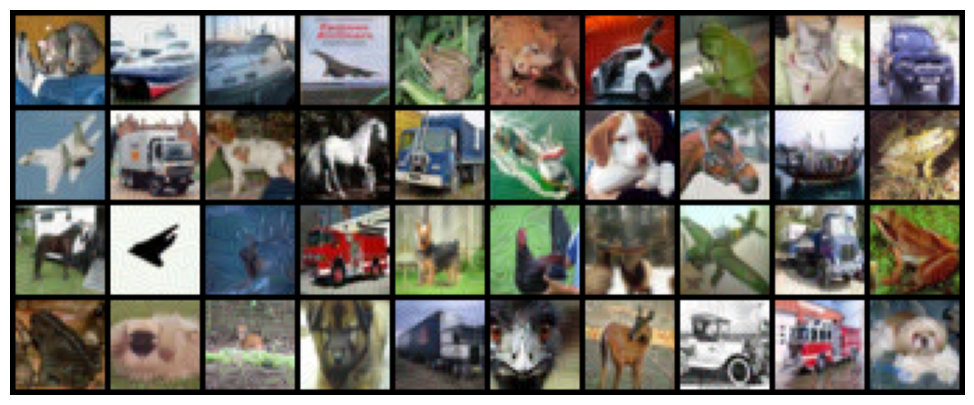

In [14]:
### START CODE HERE ### (approx. 7 lines)
plt.figure(figsize=(14,5))
plt.axis('off')
grid_img = torchvision.utils.make_grid(advs_bim[0:40], nrow=10, normalize=True)
plt.imshow(grid_img.permute(1,2,0).detach());
### END CODE HERE ###

Compare the resulting perturbation norm with the perturbation norm of the adversarial images produced by FGSM, and plot both perturbations.

tensor(3.1626)
tensor(1.1061)


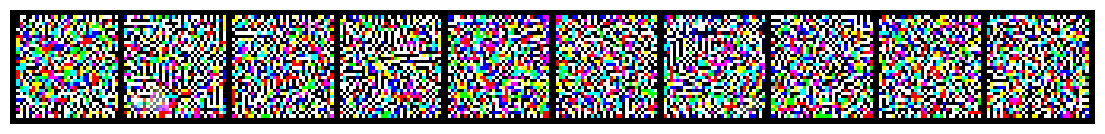

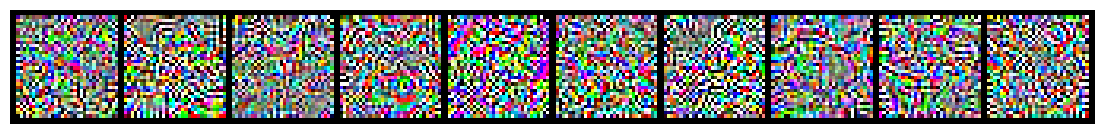

In [15]:
### START CODE HERE ### (approx. 7 lines)
print(torch.mean(torch.norm(perturbations, dim=(2,3))))
plt.figure(figsize=(14,5))
plt.axis('off')
grid_img = torchvision.utils.make_grid(perturbations[0:10], nrow=10, normalize=True)
plt.imshow(grid_img.permute(1,2,0), vmin=-1, vmax=1)

print(torch.mean(torch.norm(perturbations_bim, dim=(2,3))))
plt.figure(figsize=(14,5))
plt.axis('off')
grid_img = torchvision.utils.make_grid(perturbations_bim[0:10], nrow=10, normalize=True)
plt.imshow(grid_img.permute(1,2,0), vmin=-1, vmax=1)
### END CODE HERE ###